#  <font color=red>Parameterized Quantum Circuit for Building a Bell State</font>
In this project, we want to implement a circuit which returns $|00\rangle$ and $|11\rangle$ with equal probability. In addition, a circuit is designed to show whether the output state is $|\psi^+\rangle = \frac{1}{\sqrt 2 }( |00\rangle + |11\rangle)$ or $|\psi^-\rangle = \frac{1}{\sqrt 2 }( |00\rangle - |11\rangle)$.

The circuit is a Parameterized Quantum Circuit (PQC), for more information you can see [Parameterized quantum circuits as machine learning models](https://arxiv.org/abs/1906.07682), consisting only of CNOTs, RXs, and RYs. Using optimization methods, the purpose is to find the parameters of this circuit in a way that the circuit outputs $|00\rangle$ and $|11\rangle$ with equal probability. Simulations are done by sampling, i.e. limited numbers of measurements per iteration and noise. 

In the following, the noise model can be found.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
from math import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer, Aer
from qiskit.tools.visualization import circuit_drawer
import numpy as np
from qiskit.visualization import plot_histogram
import random
import math
import qiskit.providers.aer.noise as noise
from IPython.display import clear_output
import xarray as xr

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rx', 'ry'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

backend = Aer.get_backend('qasm_simulator')


/Users/macbookpro/anaconda3/envs/env1Q/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


We know that the following circuit creates Bell state. 


<img src = "BellCircuit.png" style = "width:400px"/>
<p style="text-align: center;"> <font size="1"> Quantum circuit to create Bell states, and its input–ouput quantum ‘truth table’. The picture is from Nielsen, M.A. and Chuang, I.L., Quantum Computation and Quantum Information book. </font> </p>

In addition, we know that $H = R^\pi_x R^{\frac{\pi}{2}}_y$. Based on the value of argument *ideal_circuit* in <font color=blue>buid_circuit</font> function, two types of circuits are built. If *ideal_circuit* assigns to <font color=green>True</font>, <font color=blue>buid_circuit</font> considers the fact that we are looking for the above circuit and $H = R^\pi_x R^{\frac{\pi}{2}}_y$. Otherwise, it creates a more general circuit consisting two rotaion gates for each qubit.

In [2]:
def buid_circuit(thetas, ideal_circuit, testing_phase = False, measure_all= False):
    
    
    if(testing_phase == True):
        qr = QuantumRegister(4, 'qr')
        if(measure_all == True):
            cr = ClassicalRegister(4, 'cr')
        else:
            cr = ClassicalRegister(2, 'cr')
    else:
        qr = QuantumRegister(2, 'qr')
        cr = ClassicalRegister(2, 'cr')
    
    circuit = QuantumCircuit(qr, cr, name="initializer_circ")

    circuit.ry(thetas[0],qr[0])
    circuit.rx(thetas[1],qr[0])
    
    #test with more gates, not considering the fact that how H can be made by ry and rx
    if ideal_circuit == False:
        circuit.ry(thetas[2],qr[1])
        circuit.rx(thetas[3],qr[1])
        
    circuit.cx(qr[0],qr[1])
    
    return circuit

In [3]:
def measure_circuit(circuit, number_of_shots):
    circuit.measure([0,1],[0,1])
    job = execute(circuit, backend, basis_gates=basis_gates,
                 noise_model=noise_model, shots=number_of_shots)
    list_of_results = job.result().get_counts(circuit)
    
    return list_of_results

The following function calculates the state vector based on the measurement results. Therefore, the imaginary part and the sign of the phase factor of the state cannot affect the calculation. For instance, there will be no difference between $|11\rangle$ and $-i|11\rangle$.

In [4]:
def calculate_approximate_state_vector(resultsDic):
    state_vector=np.zeros((4), dtype=float)
    states = (['00','01','10','11'])
    
    for i in range(4):
        state_vector[i]=resultsDic.get(states[i])
                 
    np.nan_to_num(state_vector,0.0)
    state_vector=np.sqrt((state_vector/np.sum(state_vector)))
    
    return state_vector

### Loss Function:
The desired output state of the circuit is $|\psi^+\rangle = \frac{1}{\sqrt 2 }( |00\rangle + |11\rangle)$. Therefore, the loss function is defined by using the inner product between $ |\psi^+\rangle $ and the state vector of the circuit's output, $ |\mathcal{U_\theta}\rangle$:
$$ Loss = 1 - \langle \mathcal{U_\theta} | \psi^+\rangle$$

In [5]:
def calculate_loss(state_vector):
    desired_state =  np.array([1/np.sqrt(2),0, 0, 1/np.sqrt(2)]) 
    loss_value = 1-np.inner(desired_state,state_vector)
    
    return loss_value

In [6]:
def loss_function(params, number_of_measurements ,ideal_circuit):
    circuit = buid_circuit(params, ideal_circuit)
    resultsDic = measure_circuit(circuit, number_of_measurements)
    circuit_output_vector = calculate_approximate_state_vector(resultsDic)
    loss_value = calculate_loss(circuit_output_vector)
    
    return loss_value
    

## Powell Optimization
Here, *scipy.optimize* and Powell method are used to find the optimal parameters. As the procedures are done by measurements, results for different numbers of measurements are investigated.

In [7]:
import scipy.optimize as opt

results_Powell = np.array([1, 2, 3, 4], dtype=float)
params = np.random.rand(2)
ideal_circuit = True
results_Powell = np.array([0, 0, 0, 0], dtype=float)

for i in range(4):
    results_Powell =  opt.minimize(loss_function, params, args=( 10**i, ideal_circuit), method='Powell')

In [8]:
import scipy.optimize as opt

params = np.random.rand(2)
ideal_circuit = True

list_circ_from_Powell = [QuantumCircuit() for i in range(4)]
results_Powell = [None]*4
for i in range(4):
    params = np.random.rand(2)
    results_Powell[i] =  opt.minimize(loss_function, params, args=( 10**i, ideal_circuit), method='Powell')
    list_circ_from_Powell[i]=(buid_circuit(results_Powell[i].x, ideal_circuit))

list_circ_from_Powell[3].draw()

┌─────────────┐┌───────────┐     
qr_0: |0>┤ Ry(0.47856) ├┤ Rx(1.529) ├──■──
         └─────────────┘└───────────┘┌─┴─┐
qr_1: |0>────────────────────────────┤ X ├
                                     └───┘
 cr_0: 0 ═════════════════════════════════
                                          
 cr_1: 0 ═════════════════════════════════

##### Comparing the Results of Powell Method Optimization with Different Number of Measurements

Optimization results are displayed in the following graph. Each result circuit is measured 1000 times to explore whether they output $|00\rangle$ and  $|11\rangle$ with the same probabilities. According to the following histogram, when measurement number is only 1, parameters cannot be found accurately, and the probabilities of outputting $|00\rangle$ and  $|11\rangle$ are far from 0.5. On the other hand, for 10, 100, and 1000 number of measurements, Powell performs acceptably in finding the optimum parameters and the result circuits return $|00\rangle$ and  $|11\rangle$ with and approximately equal probability of 0.5.

Few results of measurements are $|01\rangle$ or  $|10\rangle$ which are due to the noise models applied on the gates.

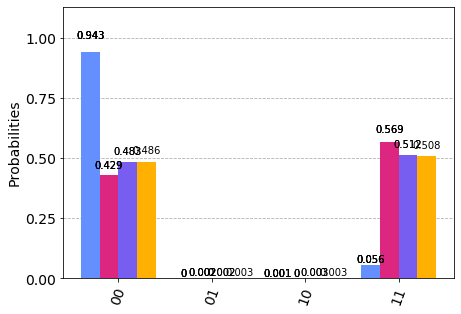

In [9]:
plot_histogram([measure_circuit(list_circ_from_Powell[0], 1000),measure_circuit(list_circ_from_Powell[1], 1000)\
                ,measure_circuit(list_circ_from_Powell[2], 1000),measure_circuit(list_circ_from_Powell[3], 1000)])

### Circuit with Four Rotation Gates
Now, let's see the results for more general circuits:

In [10]:
params = np.random.rand(4)
ideal_circuit = False

list_circ_from_Powell_G = [QuantumCircuit() for i in range(4)]
results_Powell_G = [None]*4
for i in range(4):
    params = np.random.rand(4)
    results_Powell_G[i] =  opt.minimize(loss_function, params, args=( 10**i, ideal_circuit), method='Powell')
    list_circ_from_Powell_G[i]=(buid_circuit(results_Powell_G[i].x, ideal_circuit))

list_circ_from_Powell_G[3].draw()

┌────────────┐ ┌─────────────┐     
qr_0: |0>──┤ Ry(1.5911) ├─┤ Rx(-3.0811) ├──■──
         ┌─┴────────────┴┐├─────────────┤┌─┴─┐
qr_1: |0>┤ Ry(-0.054165) ├┤ Rx(0.02235) ├┤ X ├
         └───────────────┘└─────────────┘└───┘
 cr_0: 0 ═════════════════════════════════════
                                              
 cr_1: 0 ═════════════════════════════════════

Expectedly, the results of circuits with four rotation gates are less accurate but still acceptable. In this implementation, there are more gates and noise models have more effects on the output, consequently.

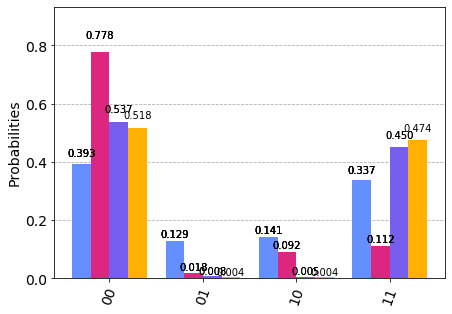

In [11]:
plot_histogram([measure_circuit(list_circ_from_Powell_G[0], 1000),measure_circuit(list_circ_from_Powell_G[1], 1000)\
                ,measure_circuit(list_circ_from_Powell_G[2], 1000),measure_circuit(list_circ_from_Powell_G[3], 1000)])

### Gradient Descent 

Let us write a simple gradient descent algorithm. In the following, a *gradient_* function calculates the gradient of a function with respect to the given parameters, using the following equation
$$ m = \frac{f(x+h) - f(x-h)}{2h} $$

In [12]:
# gradient(theta[i]) = function(theta)
def gradient_(func, params, number_of_measurements ,ideal_circuit, h=pi/2):
    param_length = len(params)
    grad = np.zeros(param_length, dtype=float)
    
    for i in range(param_length):
        
        grad[i] = (func(np.concatenate((params[0:i],[params[i]+h],params[i+1:]))\
                        ,number_of_measurements ,ideal_circuit)
                - func(np.concatenate((params[0:i],[params[i]-h],params[i+1:]))\
                       ,number_of_measurements ,ideal_circuit))/(2*h)
    return grad
    

In [13]:
def print_GD_message(number_of_iteration, optimized_value, parameters_value):
    print('Optimization terminated after',number_of_iteration, 'number of iterations.', \
          '\nFunction value:', optimized_value, '\nParameters:', parameters_value)

In [14]:
def gradient_descent(func, params, number_of_measurements, ideal_circuit, grad_h,\
                     number_of_iteration, learning_rate, plot=False):
    fig = None
    f_vals = []
    
    for i in range(number_of_iteration):
        
        params -=learning_rate*gradient_(func, params, number_of_measurements, ideal_circuit, grad_h)
    
        f_vals.append(func(params, number_of_measurements, ideal_circuit))
        results = xr.Dataset(
            {
             "f_vals": xr.DataArray(f_vals, dims=['episode'])
            }
        )
        if plot:
                clear_output(wait=True)
                fig = plt.figure(0, figsize=(12, 8))
                if ideal_circuit :
                    l = 'Loss Function For '+str(number_of_measurements)+\
                    ' Number of Measurements and 2 rotation gates'
                else:
                    l = 'Loss Function For '+str(number_of_measurements)+\
                    ' Number of Measurements and 4 rotation gates'
                plt.plot(results.f_vals, color='k', label=l)
                plt.title('Learning Bell State by GD')
                plt.legend()
                plt.xlabel('Iteration')
                plt.ylabel("Loss Function Value")
                plt.show()
                
    if (plot==False):        
        print_GD_message(number_of_iteration, func(params, number_of_measurements ,ideal_circuit), params)
    return fig,params
        

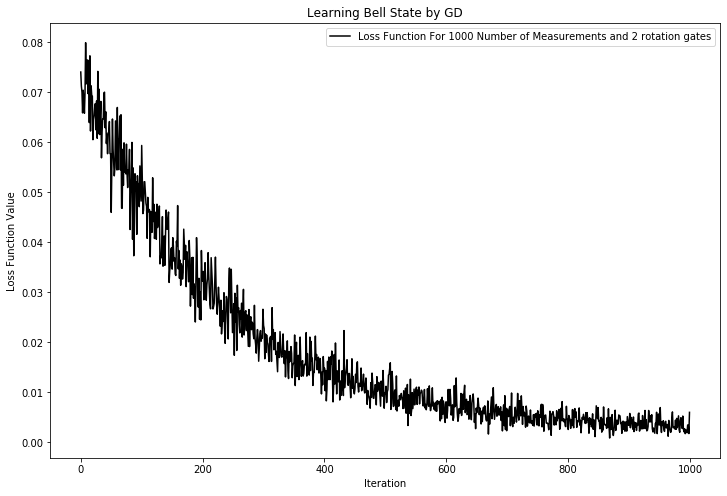

In [15]:
ideal_circuit = True
grad_h = pi/16 
number_of_iteration = 1000
learning_rate = 0.01
fig = None
list_circ_from_GD = [QuantumCircuit() for i in range(4)]
results_GD = [None]*4

for i in range(4):
    plot=False
    params = np.random.rand(2)
    if(i==2 or i==3):
            plot=True
    fig, results_GD[i] =  gradient_descent(loss_function, params, 10**i, ideal_circuit,\
                          grad_h, number_of_iteration, learning_rate, plot)
    if fig:
        fig.savefig(f'run_{i}.png', bbox_inches='tight', dpi=300)

In [16]:
for i in range(4):
    list_circ_from_GD[i]=(buid_circuit(results_GD[i], ideal_circuit)) 
list_circ_from_GD[3].draw()

┌─────────────┐┌────────────┐     
qr_0: |0>┤ Ry(0.28202) ├┤ Rx(1.4896) ├──■──
         └─────────────┘└────────────┘┌─┴─┐
qr_1: |0>─────────────────────────────┤ X ├
                                      └───┘
 cr_0: 0 ══════════════════════════════════
                                           
 cr_1: 0 ══════════════════════════════════

### Comparing the Results of Gradient Descent Optimization with Different Number of Measurements

Optimization results are shown in the following graph. Each result circuit is measured 1000 times to explore whether they output $|00\rangle$ and  $|11\rangle$ with the same probabilities. According to the following histogram, when measurement number is only 1, parameters cannot be found accurately, and the probabilities of outputting $|00\rangle$ and  $|11\rangle$ are far from 0.5 in comparison with the results of those with more measurement numbers. For 10, 100, and 1000 number of measurements, the implemented gradient descent performs acceptably in finding the optimum parameters and the result circuits return $|00\rangle$ and  $|11\rangle$ with an approximately equal probability of 0.5.

Few results of measurements are $|01\rangle$ or  $|10\rangle$ which are due to the noise models applied on the gates.

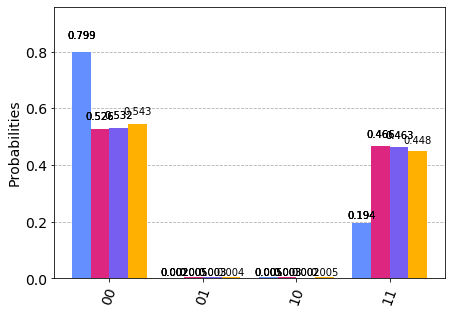

In [17]:
plot_histogram([measure_circuit(list_circ_from_GD[0], 1000),measure_circuit(list_circ_from_GD[1], 1000)\
                ,measure_circuit(list_circ_from_GD[2], 1000),measure_circuit(list_circ_from_GD[3], 1000)])

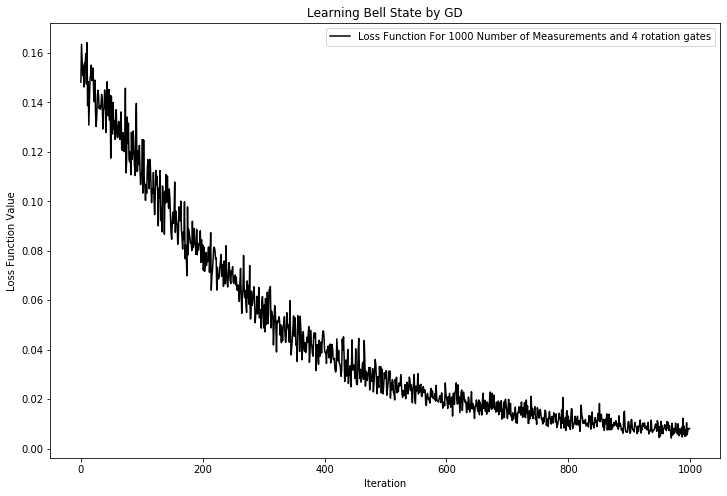

In [18]:
ideal_circuit = False

list_circ_from_GD_G = [QuantumCircuit() for i in range(4)]
results_GD_G = [None]*4
for i in range(4):
    
    params = np.random.rand(4)
    fig, results_GD_G[i] =  gradient_descent(loss_function, params, 10**i, ideal_circuit,\
                          grad_h, number_of_iteration, learning_rate, True )
    if fig:
        fig.savefig(f'run_4Rgate_{i}.png', bbox_inches='tight', dpi=300)

## Comparing Convergence Rate for Different Number of Measurements

The following graphs show that a higher number of measurements result in a higher convergence rate and lower variance. In addition, the loss function cannot converge to the optimum when there is only one measurement during the gradient descent procedure.

<table><tr><td><img src='run_4Rgate_0.png'></td><td><img src='run_4Rgate_1.png'></td></tr></table>
<table><tr><td><img src='run_4Rgate_2.png'></td><td><img src='run_4Rgate_3.png'></td></tr></table>

In [19]:
for i in range(4):
    list_circ_from_GD_G[i]=(buid_circuit(results_GD_G[i], ideal_circuit)) 
list_circ_from_GD_G[3].draw()

┌────────────┐ ┌─────────────┐      
qr_0: |0>─┤ Ry(1.2984) ├─┤ Rx(0.88012) ├───■──
         ┌┴────────────┴┐├─────────────┴┐┌─┴─┐
qr_1: |0>┤ Ry(0.074242) ├┤ Rx(0.063533) ├┤ X ├
         └──────────────┘└──────────────┘└───┘
 cr_0: 0 ═════════════════════════════════════
                                              
 cr_1: 0 ═════════════════════════════════════

The histogram for the results of circuits with four rotation gates is shown below. The results show that when the number of measurements is 1, gradient descent cannot find the optimum value. On the other hand, for 10, 100, and 1000 number of measurements, results are approximately the same and circuits output $|00\rangle$ and  $|11\rangle$ with approximately equal probabilities.

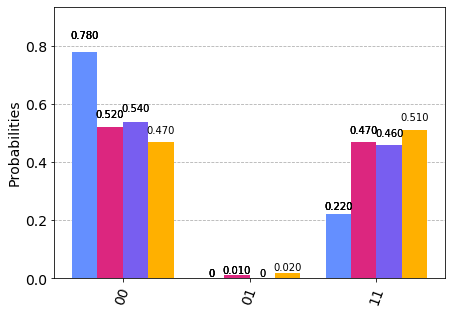

In [20]:
plot_histogram([measure_circuit(list_circ_from_GD_G[0], 100),measure_circuit(list_circ_from_GD_G[1], 100)\
                ,measure_circuit(list_circ_from_GD_G[2], 100),measure_circuit(list_circ_from_GD_G[3], 100)])

## Bonus Part:

In this part, we want to see whether the circuit outputs $|\psi^+\rangle = \frac{1}{\sqrt 2 }( |00\rangle + |11\rangle)$ or $|\psi^-\rangle = \frac{1}{\sqrt 2 }( |00\rangle - |11\rangle)$, without destroying the output by measurement. To do so, The following circuit is designed. In this circuit, measurements of the third and fourth qubits show which of the Bell states are created in the first and second qubits. For more information see [Deterministic Bell State Discrimination](https://arxiv.org/abs/quant-ph/0504183).

<img src = "Bell State Discrimination Circ.png" style = "width:400px"/> <img src = "Bell State Discrimination table.png" style = "width:400px"/>

<p style="text-align: center;"> <font size="1"> The picture is from Manu Gupta and Prasanta K. Panigrahi, Deterministic Bell State Discrimination paper. </font> </p>

In [21]:
def deterministic_Bell_state_discriminator(parameters, ideal_circuit, number_of_shots, measure_all):
    
    circuit_plus_discriminator = buid_circuit(parameters, ideal_circuit, True, measure_all)

    circuit_plus_discriminator.h([2])
    circuit_plus_discriminator.cx([2],[0])
    circuit_plus_discriminator.cx([2],[1])
    circuit_plus_discriminator.h([2])

    circuit_plus_discriminator.h([3])
    circuit_plus_discriminator.h([1])
    circuit_plus_discriminator.h([0])
    circuit_plus_discriminator.cx([3],[0])
    circuit_plus_discriminator.cx([3],[1])
    circuit_plus_discriminator.h([1])
    circuit_plus_discriminator.h([0])
    circuit_plus_discriminator.h([3])


    if(measure_all == True):
        circuit_plus_discriminator.measure([0,1,2,3],[0,1,2,3])
    else:
        circuit_plus_discriminator.measure([2,3],[0,1])
    job = execute(circuit_plus_discriminator, backend, basis_gates=basis_gates,
                noise_model=noise_model, shots=number_of_shots)
    list_of_results = job.result().get_counts(circuit_plus_discriminator)

    return list_of_results,circuit_plus_discriminator

    

To make sure that the circuit work correctly, let us measure all the circuits. Parameters are obtained by gradient descent with 100 and 1000 measurements.

In [35]:
ideal_circuit = True
number_of_shots =  1000

measurement_results1, Bell_state_discriminator1 = deterministic_Bell_state_discriminator\
                        (results_GD[2],ideal_circuit,number_of_shots,True)
measurement_results2, Bell_state_discriminator2 = deterministic_Bell_state_discriminator\
                        (results_GD[3],ideal_circuit,number_of_shots,True)
Bell_state_discriminator1.draw()

┌────────────┐┌─────────────┐     ┌───┐┌───┐     ┌───┐┌───┐          »
qr_0: |0>┤ Ry(1.3711) ├┤ Rx(0.83221) ├──■──┤ X ├┤ H ├─────┤ X ├┤ H ├──────────»
         └────────────┘└─────────────┘┌─┴─┐└─┬─┘├───┤┌───┐└─┬─┘├───┤┌───┐     »
qr_1: |0>─────────────────────────────┤ X ├──┼──┤ X ├┤ H ├──┼──┤ X ├┤ H ├─────»
             ┌───┐                    └───┘  │  └─┬─┘├───┤  │  └─┬─┘└┬─┬┘     »
qr_2: |0>────┤ H ├───────────────────────────■────■──┤ H ├──┼────┼───┤M├──────»
             ├───┤                                   └───┘  │    │   └╥┘ ┌───┐»
qr_3: |0>────┤ H ├──────────────────────────────────────────■────■────╫──┤ H ├»
             └───┘                                                    ║  └───┘»
 cr_0: 0 ═════════════════════════════════════════════════════════════╬═══════»
                                                                      ║       »
 cr_1: 0 ═════════════════════════════════════════════════════════════╬═══════»
                                                                      ║       »
 cr_2: 0 ═════════════════════════════════════════════════════════════╩═══════»
                                                                              »
 cr_3: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌─┐      
«qr_0: ┤M├──────
«      └╥┘┌─┐   
«qr_1: ─╫─┤M├───
«       ║ └╥┘   
«qr_2: ─╫──╫────
«       ║  ║ ┌─┐
«qr_3: ─╫──╫─┤M├
«       ║  ║ └╥┘
«cr_0: ═╩══╬══╬═
«          ║  ║ 
«cr_1: ════╩══╬═
«             ║ 
«cr_2: ═══════╬═
«             ║ 
«cr_3: ═══════╩═
«

You can see that the results match the table displayed with the circuit in the previous parts.

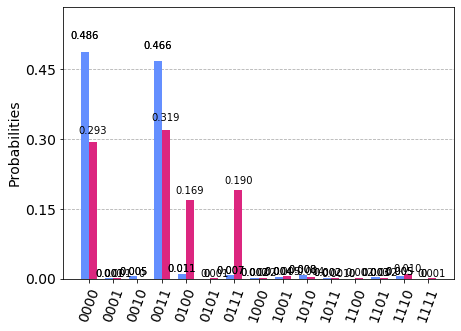

In [36]:
plot_histogram([measurement_results1,measurement_results2])

As it is clear from the previous and the following histograms , you can see that the parameters obtained by 1000 measurements result in a circuit which outputs $|\psi^-\rangle = \frac{1}{\sqrt 2 }( |00\rangle - |11\rangle)$ with a higher probability in comparison with the one with 100 measurements. The circuit with 100 measurements performs correctly and outputs $|\psi^+\rangle = \frac{1}{\sqrt 2 }( |00\rangle + |11\rangle)$ with high probability. Since in our loss function there is no difference between $|\psi^+\rangle$ and $|\psi^-\rangle$, so there is no guarantee of outputting $|\psi^+\rangle$ and these results are reasonable and predictable.

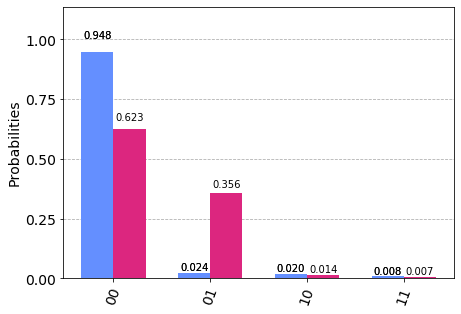

In [37]:
measurement_results_1, Bell_state_discriminator = deterministic_Bell_state_discriminator\
                        (results_GD[2],ideal_circuit,number_of_shots,False)
measurement_results_2, Bell_state_discriminator = deterministic_Bell_state_discriminator\
                        (results_GD[3],ideal_circuit,number_of_shots,False)
plot_histogram([measurement_results_1,measurement_results_2])

In the following, the circuit with four rotation gates is investigated. Parameters are obtained from gradient descent with 1000 number of measurements

In [42]:
ideal_circuit = False
number_of_shots =  1000
measurement_results_G_1, Bell_state_discriminator_G = deterministic_Bell_state_discriminator\
                            (results_GD_G[2],ideal_circuit,number_of_shots, False)
measurement_results_G_2, Bell_state_discriminator_G = deterministic_Bell_state_discriminator\
                            (results_GD_G[3],ideal_circuit,number_of_shots, False)
Bell_state_discriminator_G.draw()

┌────────────┐ ┌─────────────┐      ┌───┐┌───┐     ┌───┐┌───┐     »
qr_0: |0>─┤ Ry(1.2984) ├─┤ Rx(0.88012) ├───■──┤ X ├┤ H ├─────┤ X ├┤ H ├─────»
         ┌┴────────────┴┐├─────────────┴┐┌─┴─┐└─┬─┘├───┤┌───┐└─┬─┘├───┤┌───┐»
qr_1: |0>┤ Ry(0.074242) ├┤ Rx(0.063533) ├┤ X ├──┼──┤ X ├┤ H ├──┼──┤ X ├┤ H ├»
         └────┬───┬─────┘└──────────────┘└───┘  │  └─┬─┘├───┤  │  └─┬─┘└┬─┬┘»
qr_2: |0>─────┤ H ├─────────────────────────────■────■──┤ H ├──┼────┼───┤M├─»
              ├───┤                                     └───┘  │    │   └╥┘ »
qr_3: |0>─────┤ H ├────────────────────────────────────────────■────■────╫──»
              └───┘                                                      ║  »
 cr_0: 0 ════════════════════════════════════════════════════════════════╩══»
                                                                            »
 cr_1: 0 ═══════════════════════════════════════════════════════════════════»
                                                                            »
«              
«qr_0: ────────
«              
«qr_1: ────────
«              
«qr_2: ────────
«      ┌───┐┌─┐
«qr_3: ┤ H ├┤M├
«      └───┘└╥┘
«cr_0: ══════╬═
«            ║ 
«cr_1: ══════╩═
«

According to the following histogram, in the circuits with four rotation gates and 100 measurements, probability of outputing $|\psi^-\rangle = \frac{1}{\sqrt 2 }( |00\rangle - |11\rangle)$ is more than the circuit with 1000 measurements. Yet, the probability of outputing $|\psi^+\rangle = \frac{1}{\sqrt 2 }( |00\rangle + |11\rangle)$ in both circuits is the highest among the other Bell states.

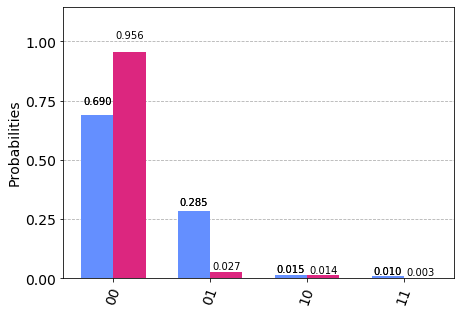

In [43]:
plot_histogram([measurement_results_G_1, measurement_results_G_2])

To make sure that the optimization results in outputting $|\psi^+\rangle = \frac{1}{\sqrt 2 }( |00\rangle + |11\rangle)$, phase factor in <font color=blue> calculate_approximate_state_vector</font> should not be neglected. Thus, one can use the <font color=blue>deterministic_Bell_state_discriminator</font> function, as well as replace H with $R^\pi_x R^\frac{\pi}{2}_y$, to build the circuit and defines the loss function in a way that its minimum is in the point that the measurement of the third and fourth qubit results in 00. As the results obtained from the current implementations are fine enough, let me implement this more elaborate design in another chance!